In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split

from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.static import teams

# Gets the box score of every single game (NBA + WNBA + others: nba.com doesn't seperate the leagues) 
# from 2014-2021 into a dataframe.
all_games_finder = leaguegamefinder.LeagueGameFinder()
all_games = all_games_finder.get_data_frames()[0]

# Creates empty dataframe with the same column names passed in from the dataframe containing all the games.
column_names = all_games.columns
games = pd.DataFrame(columns = column_names)

# Appends every game containing an NBA team in the all_games df to the games df. 
nba_teams = teams.get_teams()
for team in nba_teams:
    temp_id = team['id']
    games = games.append(all_games[all_games['TEAM_ID'] == temp_id])

games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18000 entries, 4 to 29998
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SEASON_ID          18000 non-null  object 
 1   TEAM_ID            18000 non-null  object 
 2   TEAM_ABBREVIATION  18000 non-null  object 
 3   TEAM_NAME          18000 non-null  object 
 4   GAME_ID            18000 non-null  object 
 5   GAME_DATE          18000 non-null  object 
 6   MATCHUP            18000 non-null  object 
 7   WL                 17992 non-null  object 
 8   MIN                18000 non-null  object 
 9   PTS                18000 non-null  object 
 10  FGM                18000 non-null  object 
 11  FGA                18000 non-null  object 
 12  FG_PCT             17998 non-null  float64
 13  FG3M               18000 non-null  object 
 14  FG3A               18000 non-null  object 
 15  FG3_PCT            17997 non-null  float64
 16  FTM                180

In [2]:
# Dropping any game (two rows in DF) that has any NaN values.

games.isna()
games.dropna(inplace = True)

games = games[games.duplicated(subset = ['GAME_ID'], keep = False)]
 
# Merging games together (previously seperated in the DF by team: each team's stats from the game were kept in seperate rows)
games = games.sort_values(by=['GAME_ID'])

gamesteam1 = games[games.index % 2 == 0]
gamesteam2 = games[games.index % 2 == 1]

gamesteam1 = gamesteam1.reset_index(drop=True)
gamesteam2 = gamesteam2.reset_index(drop=True)

games = gamesteam1.join(gamesteam2, rsuffix='_other')

games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8946 entries, 0 to 8945
Data columns (total 56 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   SEASON_ID                8946 non-null   object 
 1   TEAM_ID                  8946 non-null   object 
 2   TEAM_ABBREVIATION        8946 non-null   object 
 3   TEAM_NAME                8946 non-null   object 
 4   GAME_ID                  8946 non-null   object 
 5   GAME_DATE                8946 non-null   object 
 6   MATCHUP                  8946 non-null   object 
 7   WL                       8946 non-null   object 
 8   MIN                      8946 non-null   object 
 9   PTS                      8946 non-null   object 
 10  FGM                      8946 non-null   object 
 11  FGA                      8946 non-null   object 
 12  FG_PCT                   8946 non-null   float64
 13  FG3M                     8946 non-null   object 
 14  FG3A                    

In [3]:
#Things to drop later:
#team ID, not relevant and good teams might be identified by this => more bias
#Ironically, block percentage only really correlates to total blocks (maybe not, bc there's a few blocks that also correlate either negatively or positively to blkp)
#Maybe freethrough percent? It correlates to a few other things so I'm not sure If we should really. 
games = games.drop(columns=['SEASON_ID_other', 'GAME_DATE_other']) #irrelevant and basically an exact duplicate of that in the first column.
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8946 entries, 0 to 8945
Data columns (total 54 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   SEASON_ID                8946 non-null   object 
 1   TEAM_ID                  8946 non-null   object 
 2   TEAM_ABBREVIATION        8946 non-null   object 
 3   TEAM_NAME                8946 non-null   object 
 4   GAME_ID                  8946 non-null   object 
 5   GAME_DATE                8946 non-null   object 
 6   MATCHUP                  8946 non-null   object 
 7   WL                       8946 non-null   object 
 8   MIN                      8946 non-null   object 
 9   PTS                      8946 non-null   object 
 10  FGM                      8946 non-null   object 
 11  FGA                      8946 non-null   object 
 12  FG_PCT                   8946 non-null   float64
 13  FG3M                     8946 non-null   object 
 14  FG3A                    

In [4]:
games["BLK%"] = 100 * (games["BLK"] * (games["MIN"]/5))/ (games["MIN"] * (games["FGA_other"] - games["FG3A_other"])) 

#Turnover Percentage (TOV)             | TOV / (FGA + 0.44 * FTA + TOV)     TOV = turnovers
games["TOV%"] = games["TOV"] / (games["FGA"] + 0.44*games["FTA"] + games["TOV"])

#Offensive Rebound Percentage (ORB)    | ORB / (ORB + Opp DRB)              Opp = oppenent
games["ORB%"] = games["OREB"] / (games["OREB"] + games["DREB_other"])

#Defensive Rebound Percentage (DRB)    | DRB / (Opp ORB + DRB)              Opp = oppenent
games["DREB%"] = games["DREB"] / (games["OREB_other"] + games["DREB"])

#(POSS)
# need to get the bloody parenthesis correctly done!
#games["POSS"] = 0.5*((games["FGA"] + 0.4*games["FTA"] - 1.07*(games["OREB"]/(games["OREB"] + games["OREB_other"])) * (games["FGA"] - games["FGM"]) + games["TOV"]) + games["FGA_other"] + 0.4*games["FTA_other"] - 1.07 * (games["OREB_other"] / (games["OREB_other"] + games["DREB"])) * (games["FGA_other"] - games["FGM_other]) + games["TOV_other"]))

# simpler POSS
games["POSS"] = 0.96*((games["FGA"]) + games["TOV"] + 0.44*games["FTA"] - games["OREB"])

# used for PACE; probably wrong
games["POSS_other"] = 0.96*((games["FGA_other"]) + games["TOV_other"] + 0.44*games["FTA_other"] - games["OREB_other"])

#STLP
games["STL%"] = 100 * (games["STL"] * (games["MIN"]/5))/ (games["MIN"] * games["POSS"]) #need POSS feature

#FTR
games["FTR"] = games["FTM"] / games["FGA"]

#TS (you'll need to calculate TSA as well)
games["TSA"] = games["FGA"] + 0.44*games["FTA"]
games["TS"] = games["PTS"]/(2*games["TSA"])

#ASTR
games["ASTR"] = 100*games["AST"]/ (((games["MIN"]/(games["MIN"]/5)) * games["FGM"]) - games["FGM"])

#TRB
games["TRB%"] = 100*(games["REB"] * (games["REB"]/5))/(games["MIN"] * (games["REB"] + games["REB_other"]))

#PACE
games["PACE"] = 48*((games["POSS"] + games["POSS_other"])/(2*(games["MIN"]/5)))

#ORTG
games["ORTG"] = 100*(games["PTS"]/games["POSS"])

#DRTG
games["DRTG"] = 100*(games["PTS_other"]/games["POSS"])

#PER

print(games.columns)
games.head(10)

Index(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'PTS', 'FGM', 'FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS', 'TEAM_ID_other',
       'TEAM_ABBREVIATION_other', 'TEAM_NAME_other', 'GAME_ID_other',
       'MATCHUP_other', 'WL_other', 'MIN_other', 'PTS_other', 'FGM_other',
       'FGA_other', 'FG_PCT_other', 'FG3M_other', 'FG3A_other',
       'FG3_PCT_other', 'FTM_other', 'FTA_other', 'FT_PCT_other', 'OREB_other',
       'DREB_other', 'REB_other', 'AST_other', 'STL_other', 'BLK_other',
       'TOV_other', 'PF_other', 'PLUS_MINUS_other', 'BLK%', 'TOV%', 'ORB%',
       'DREB%', 'POSS', 'POSS_other', 'STL%', 'FTR', 'TSA', 'TS', 'ASTR',
       'TRB%', 'PACE', 'ORTG', 'DRTG'],
      dtype='object')


,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,POSS_other,STL%,FTR,TSA,TS,ASTR,TRB%,PACE,ORTG,DRTG
0,12015,1610612746,LAC,LA Clippers,0011500001,2015-10-02,LAC vs. DEN,W,238,103,...,100.608,2.348741,0.21978,102.44,0.502733,14.864865,1.331408,102.247261,100.800138,93.949643
1,12015,1610612754,IND,Indiana Pacers,0011500003,2015-10-03,IND vs. NOP,L,241,105,...,93.4656,1.953613,0.206522,105.64,0.496971,13.815789,2.981347,97.513693,102.564704,97.68067
2,12015,1610612740,NOP,New Orleans Pelicans,0011500003,2015-10-03,NOP @ IND,W,242,110,...,92.544,1.684939,0.242718,119.28,0.4611,10.810811,2.604167,98.862545,102.968488,99.224179
3,12015,1610612747,LAL,Los Angeles Lakers,0011500004,2015-10-04,LAL vs. UTA,L,238,71,...,92.2752,1.696526,0.144444,99.24,0.357719,10.576923,1.792717,94.076773,75.28332,95.42956
4,12015,1610612761,TOR,Toronto Raptors,0011500005,2015-10-04,TOR vs. LAC,W,241,93,...,94.848,2.52934,0.39726,88.84,0.523413,8.870968,2.360535,94.47356,98.011938,76.934102
5,12015,1610612766,CHA,Charlotte Hornets,0011500006,2015-10-04,CHA @ MIA,W,240,90,...,91.008,1.509037,0.351351,87.64,0.513464,12.5,2.253333,91.8912,97.00952,82.997034
6,12015,1610612757,POR,Portland Trail Blazers,0011500007,2015-10-05,POR vs. SAC,L,266,105,...,89.8176,2.082576,0.111111,106.04,0.495096,14.285714,2.284363,88.175639,99.395674,89.92942
7,12015,1610612758,SAC,Sacramento Kings,0011500007,2015-10-05,SAC @ POR,W,265,109,...,102.4512,1.85482,0.197802,103.32,0.527487,14.880952,1.986097,95.220408,101.087666,108.506944
8,12015,1610612761,TOR,Toronto Raptors,0011500009,2015-10-05,TOR @ GSW,L,240,87,...,106.2528,2.213486,0.223529,95.12,0.457317,11.71875,2.021053,98.304,96.286655,142.769868
9,12015,1610612747,LAL,Los Angeles Lakers,0011500010,2015-10-07,LAL vs. UTA,L,265,114,...,102.4512,1.732262,0.421687,103.24,0.552112,11.111111,1.268679,93.446762,109.709904,101.048596


In [5]:
# code below updates the games.csv with the new features added
# and saves it to games_updated.cs

games_csv = games
games_csv.to_csv("games_updated.csv")

<AxesSubplot:>

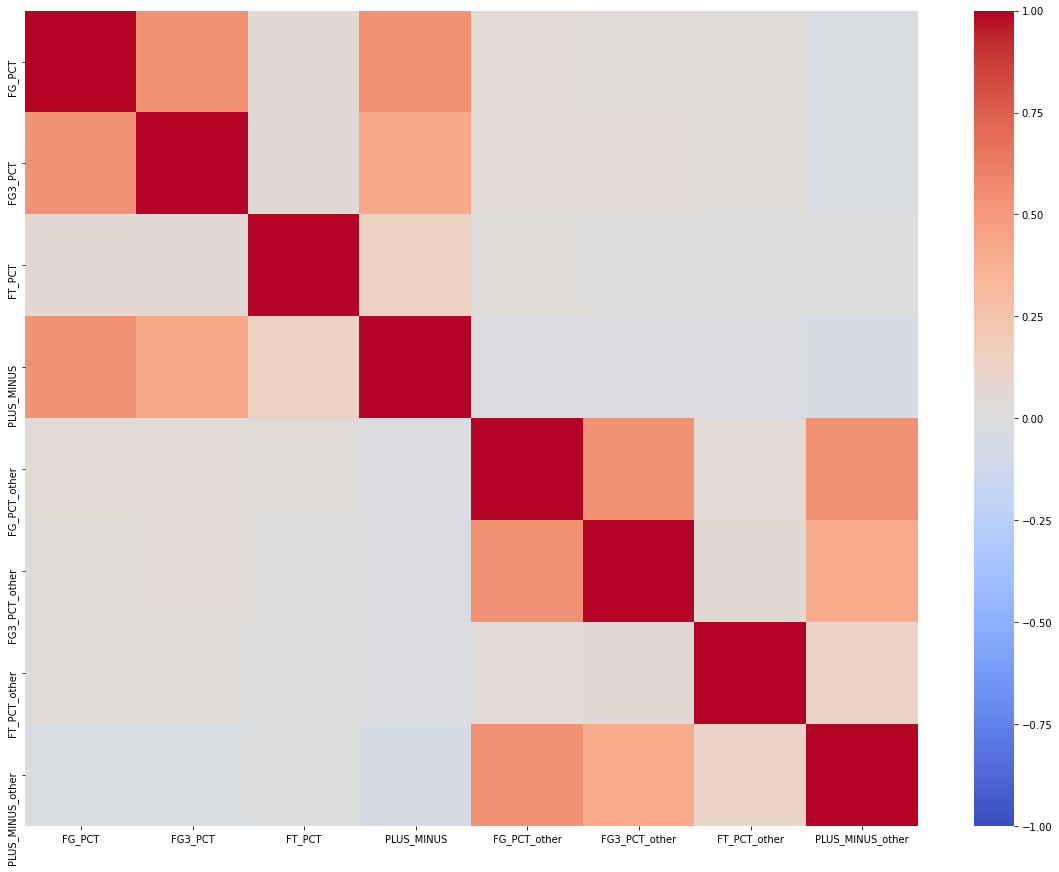

In [6]:
#Data Visualizaiton
plt.figure(figsize=(20,15))
sns.heatmap(games.corr(),cmap='coolwarm', vmin = -1)

In [ ]:
# ~ TO-DO: 
#  > simple statistics for each feature; mean, median, nth quartile, ...
#  > simple histogram; just to show basic statistics
#  > cleanup, normalize data (???)
#  > udpate document report